- Raw data are aviable in: 

https://metadata.icmyl.unam.mx/bitstream/handle/20.500.12201/11367/MartinezTrejo_etal_2023_TA_DIC_RawData.csv?sequence=1&isAllowed=y



- Read csv  data file

In [1]:
# Import packages
import pandas as pd
import PyCO2SYS as pyco2
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Function to read in csv file
def read_csv(file):
    """
    Read in csv file and return pandas dataframe
    """
    df = pd.read_csv(file, sep=",", header=0,  decimal=".", encoding='utf-8')
    return df

In [3]:
# define file path 
terminos_ta_dic_data_path = "../data/MartinezTrejo_etal_2023_TA_DIC_RawData.csv"

# Read in data
terminos_ta_dic_raw = read_csv(terminos_ta_dic_data_path)

# Copy raw data to new dataframe
terminos_ta_dic = terminos_ta_dic_raw.copy()

# Delete the raw DataFrame
del terminos_ta_dic_raw

### Calculate  [TA - DIC] 

In [4]:
# Calculate TA - DIC (TA-DIC)  
terminos_ta_dic["TA-DIC"] = terminos_ta_dic["TA_micromol_kg"] - terminos_ta_dic["DIC_micromol_kg"]


### Calculate the apparent oxygen utilization (AOU) as the difference between the measured oxygen concentration and the oxygen concentration in equilibrium with the atmosphere at the same temperature and salinity.

In [5]:
from convert_oxygen_concentration_AOU import convert_oxygen_concentration
from convert_oxygen_concentration_AOU import calculate_aou


# Convert DO from mg/L to micromol/kg
terminos_ta_dic["DO_micromol_kg"] = convert_oxygen_concentration(terminos_ta_dic["DO_mg_L"], 
                                                                terminos_ta_dic["Sal_psu"], terminos_ta_dic["Temp_C"], pressure=0) 
# Calculate Apparent Oxygen Utilization (AOU)
terminos_ta_dic["oxygen_utilization_micromol_kg"] = calculate_aou(terminos_ta_dic["Sal_psu"], terminos_ta_dic["Temp_C"],  
                                                                  0.0, terminos_ta_dic["DO_micromol_kg"], terminos_ta_dic["latitude"], 
                                                                  terminos_ta_dic["latitude"] )


## PyCO2SYS configuration from estuarine waters (Humphreys et al. 2022)

In [6]:
# Copy data to new dataframe
terminos_inorganic_carbon = terminos_ta_dic.copy()

# Create dictionary with data configuration for PyCO2SYS. 
# For more information on the parameters see Humphreys et al (2022)
my_co2sys_params_dic_ta_config = {
    # DIC measured in the lab in μmol/kg-sw
    "par1": terminos_inorganic_carbon["DIC_micromol_kg"],
    # TA measured in the lab, Total scale
    "par2": terminos_inorganic_carbon["TA_micromol_kg"],
    "par1_type": 2,         # tell PyCO2SYS: "par2 is a DIC value"
    "par2_type": 1,         # tell PyCO2SYS: "par1 is a TA value"
    # Fields conditions
    "salinity": terminos_inorganic_carbon["Sal_psu"],  # in-situ salinity in PSU
    # in-situ temperature (output conditions) in °C
    "temperature_out": terminos_inorganic_carbon["Temp_C"],
    "pressure_out": 0.0,
    # Settings
    "opt_pH_scale": 1,     # Total pH (Wolf-Gladrow et al. 2007)
    "opt_k_carbonic": 15,     # 0 < T < 50 °C, 1 < S < 50, Seawater scale, real seawater (Millero F.J. 2010)
    "temperature": 25      # lab temperature (input conditions) in °C
}

### Run PyCO2SYS

In [7]:
# Run PyCO2SYS to calculate the carbonate system parameters
terminos_inorganic_carbon_results= pyco2.sys(**my_co2sys_params_dic_ta_config)

### Read the interes variables from PYCO2sys 

In [8]:
# Select variables of interest from the PyCO2SYS output and create a DataFrame
pyco2_interest_variables = pd.DataFrame({
       "pH": terminos_inorganic_carbon_results["pH"],
       "saturation_aragonite": terminos_inorganic_carbon_results["saturation_aragonite"],
       "pCO2_atm": terminos_inorganic_carbon_results["pCO2_out"],
       "k_aragonite": terminos_inorganic_carbon_results["k_aragonite"],
       "total_calcium": terminos_inorganic_carbon_results["total_calcium"],
       "carbonate": terminos_inorganic_carbon_results["carbonate"]
      
})

# Concatenate PyCO2SYS output with the original dataframe
CarbonateTL = pd.concat([terminos_ta_dic, pyco2_interest_variables], axis=1)

- Select Candelaria and Palizada results

In [9]:
CandelariaResult = CarbonateTL.loc[CarbonateTL["Estuary"] == "Candelaria"]
                     
PalizadaResult = CarbonateTL.loc[CarbonateTL["Estuary"] == "Palizada"]

_____________

### [TA - DIC] analysis in the TL lagoon system of the southern Gulf of Mexico

- Salininty vs [TA-DIC] , and pH as color, for Candelaria and Palizada estuaries

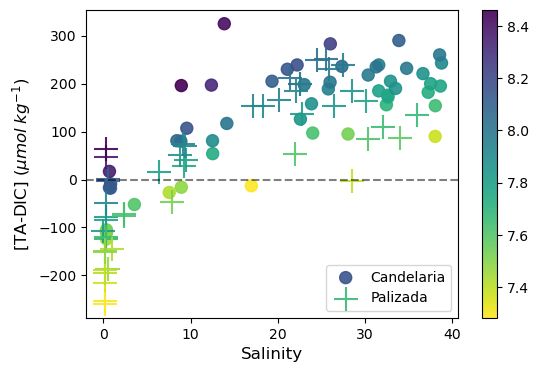

In [10]:
# Plot [TA-DIC] as a function of salinity across estuaries, colobar represents pH
# getting the original colormap using cm.get_cmap() function
orig_map = plt.colormaps.get_cmap('viridis')

# reversing the original colormap using reversed() function
reversed_map = orig_map.reversed()

scatter = plt.scatter(
    x=CandelariaResult["Sal_psu"], y=CandelariaResult["TA-DIC"], c=CandelariaResult["pH"], cmap=reversed_map,
    marker='.', s= 300, label='Candelaria', alpha=0.9)

scatter = plt.scatter(
    x=PalizadaResult["Sal_psu"], y=PalizadaResult["TA-DIC"], c=PalizadaResult["pH"], cmap=reversed_map,
    marker='+', s= 300, label='Palizada', alpha=0.9)

# Add a constant line at zero on the y-axis
plt.axhline(0, color='k', linestyle='--', alpha=0.5)

# Add a color bar
plt.colorbar(scatter)

# Add labels and title
plt.xlabel('Salinity', fontsize = 12)
plt.ylabel("[TA-DIC] ($\mu mol  \; kg^{-1}$)" , fontsize = 12)
plt.legend(loc='lower right')

# set the figure size
plt.gcf().set_size_inches(6, 4)

# save the plot as a PDF file
plt.savefig('../output_files/sal_TA-DIC_pH.pdf', dpi=300, bbox_inches='tight')

# display the plot
plt.show()

________________


- [TA-DIC] vs pH, and salinity ranges of river (0-1), estuarine(1-15), and marine waters (1-35) 

In [ ]:

# Plot [TA-DIC] vs pH regression line for each salinity range

import matplotlib.cm as cm
from sklearn.linear_model import LinearRegression


# Define salinity levels
salinity_levels = [(0, 1), (1, 15), (15, 39)]

# Generate colors from the Viridis colormap
colors = cm.viridis([0.2, 0.5, 0.8])

# Function to fit model and return predictions
def fit_and_predict(X, y):
    model = LinearRegression()
    model.fit(X, y)
    return model.predict(X)

# Function to plot data and regression line
def plot_data_and_regression(X, y, pH_pred, color, label):
    plt.scatter(X, y, color=color, label=label)
    plt.plot(X, pH_pred, color=color)

# Function to process each salinity range
def process_salinity_range(sal_range):
    # Subset the data for the current salinity range
    subset = CarbonateTL.query(f"`Sal_psu` >= {sal_range[0]} & `Sal_psu` < {sal_range[1]}")
    
    # Reshape data for model input
    X = subset["TA-DIC"].values.reshape(-1, 1)
    y = subset["pH"].values
    
    # Fit the model and get predictions
    pH_pred = fit_and_predict(X, y)
    
    # Plot the data and the regression line
    plot_data_and_regression(X, y, pH_pred, colors[salinity_levels.index(sal_range)], f'{sal_range[0]}-{sal_range[1]}')

plt.plot([], [], ' ', label=" Salinity ranges")

# Apply the function to each salinity range
list(map(process_salinity_range, salinity_levels))


# Add labels and legend
plt.xlabel('[TA-DIC] ($\mu mol  \; kg^{-1}$)')

plt.ylabel('pH')
plt.legend()
# save the plot as a PDF file

plt.savefig('../output_files/07_Fig_07_TA-DIC_vs_pH_salinity_ranges.pdf', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

- Calculate  Slope, Intercept and $R^2$ score:  [TA-DIC] vs pH, and salinity ranges of river (0-1), estuary(1-15), and marine waters (1-35) 

In [ ]:
import statsmodels.api as sm
from tabulate import tabulate

salinity_levels = [(0, 1), (1, 15), (15, 39)]

def fit_and_predict(X, y):
    X = sm.add_constant(X)  # Adding a constant (intercept term) to the model
    model = sm.OLS(y, X)
    results = model.fit()
    return results.params[1], results.params[0], results.rsquared, results.pvalues[1]

def print_results(sal_range, results):
    table = [["Salinity range", f"{sal_range[0]}-{sal_range[1]}"],
             ["Slope", results[0]],
             ["Intercept", results[1]],
             ["R^2 score", results[2]],
             ["P-value", results[3]]]
    print(tabulate(table))

for sal_range in salinity_levels:
    subset = CarbonateTL[(CarbonateTL["Sal_psu"] >= sal_range[0]) & (CarbonateTL["Sal_psu"] < sal_range[1])]
    X = subset["TA-DIC"].values.reshape(-1, 1)
    y = subset["pH"].values
    results = fit_and_predict(X, y)
    print_results(sal_range, results)

# References
- Humphreys, M. P., Lewis, E. R., Sharp, J. D., & Pierrot, D. (2022). PyCO2SYS v1.8: Marine carbonate system calculations in Python. Geoscientific Model Development, 15(1), 15–43. https://doi.org/10.5194/gmd-15-15-2022
- Millero, F. J. (2010). Carbonate constants for estuarine waters. Marine and Freshwater Research, 61(2), 139. https://doi.org/10.1071/MF09254
- Wolf-Gladrow, D. A., Zeebe, R. E., Klaas, C., Körtzinger, A., & Dickson, A. G. (2007). Total alkalinity: The explicit conservative expression and its application to biogeochemical processes. Marine Chemistry, 106(1–2), 287–300. https://doi.org/10.1016/j.marchem.2007.01.006

_____________________________